C:\Users\Marcos\AppData\Local\Temp\ipykernel_15200\1666426960.py:78: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = ndimage.interpolation.zoom(image, real_resize_factor)
C:\Users\Marcos\AppData\Local\Temp\ipykernel_15200\1666426960.py:134: DeprecationWarning: Please import `binary_closing` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)


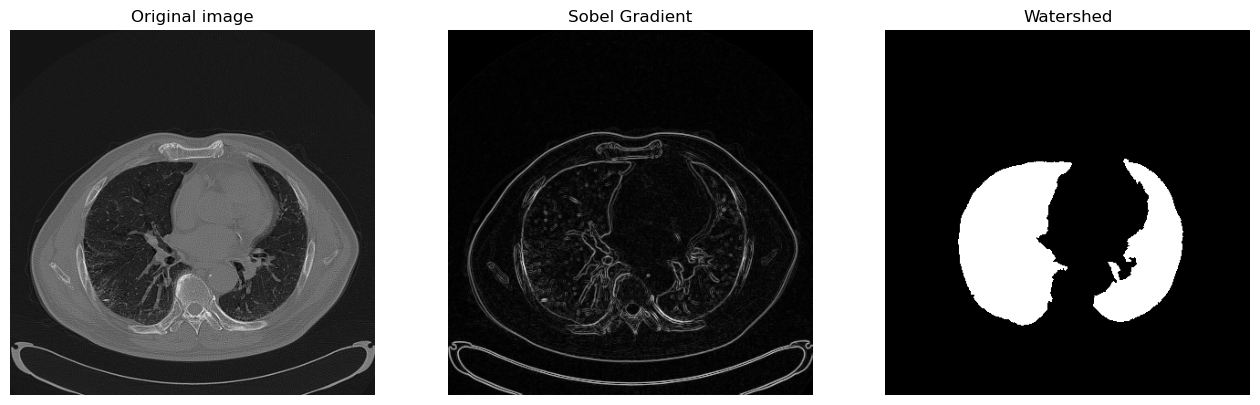

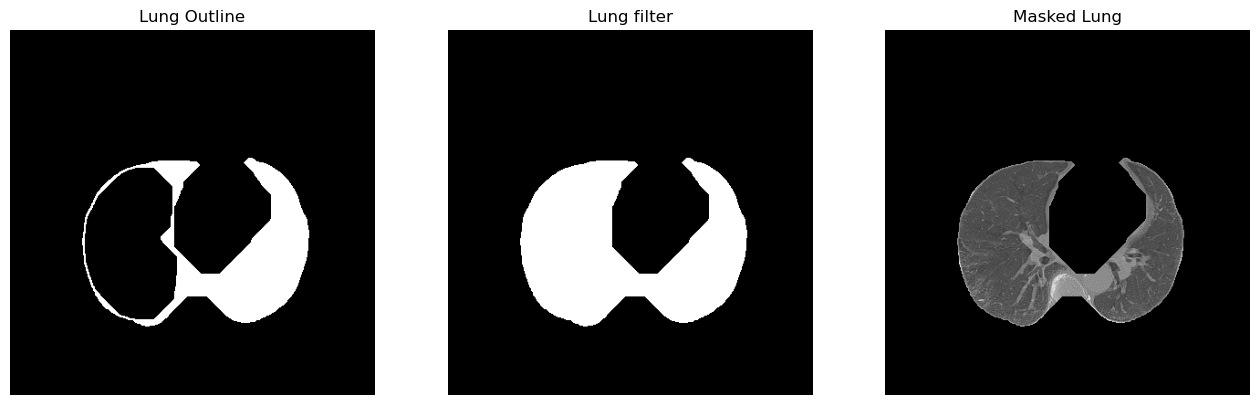

Máscara de pulmón guardada en: C:/Users/Marcos/reto-1-mas-alla-de-la-mirada-humana\masked_lungs\ID00407637202308788732304_masked_lung.png


In [3]:
import os
import numpy as np
import random
import pydicom
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage.segmentation import watershed
from skimage import measure, segmentation
import PIL
import glob


# Path para los datos del paciente
path = "C:/Users/Marcos/reto-1-mas-alla-de-la-mirada-humana"
path_imgs_train = path + '/train/'
path_imgs_test = path + '/test/'

# Definir las funciones necesarias
def loadSlices(patient_files):
    slices = [pydicom.dcmread(s) for s in patient_files]
    slices.sort(key = lambda x: float(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
            slices[0].RescaleIntercept = 1024
    
    if slice_thickness == 0:
        slice_thickness = 1
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def getPixelsHu(patient_scans):
    patient_images = []
    for s in patient_scans:
        if s.Columns != s.Rows:
            crop_size = 512
            s_crop_img = imCropCenter(s.pixel_array, crop_size, crop_size)
            patient_images.append(s_crop_img)
        else:
            patient_images.append(s.pixel_array)

    patient_images = np.asarray(patient_images).astype(np.int16)

    patient_images[patient_images == -2000] = 0
    
    intercept = patient_scans[0].RescaleIntercept
    slope = patient_scans[0].RescaleSlope
        
    if slope != 1:
        patient_images = slope * patient_images.astype(np.float64)
        patient_images = patient_images.astype(np.int16)

    patient_images += np.int16(intercept)
    patient_images = np.clip(patient_images, -2048, 3284)
    return np.array(patient_images, dtype=np.int16)

def resampleImages(image, scan, new_spacing=[1,1,1]):
    spacing = [float(scan[0].SliceThickness), 
                float(scan[0].PixelSpacing[0]), 
                float(scan[0].PixelSpacing[1])]

    spacing = np.array(spacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, spacing

def generateMarkers(image):
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    marker_watershed = np.zeros(image.shape, dtype=int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperateLungs(image, n_iters=2):
    marker_internal, marker_external, marker_watershed = generateMarkers(image)
    
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    watershed_result = watershed(sobel_gradient, marker_watershed)
    
    outline = ndimage.morphological_gradient(watershed_result, size=(3,3))
    outline = outline.astype(bool)
    
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, n_iters)
    
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    segmented = np.where(lungfilter == 1, image, -2000*np.ones(image.shape))
    
    return segmented, lungfilter, outline, watershed_result, sobel_gradient

def imCropCenter(img, w, h):
    img = PIL.Image.fromarray(img)
    img_width, img_height = img.size
    left, right = (img_width - w) / 2, (img_width + w) / 2
    top, bottom = (img_height - h) / 2, (img_height + h) / 2
    left, top = round(max(0, left)), round(max(0, top))
    right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
    return np.asarray(img.crop((left, top, right, bottom)))

# Ruta para las imágenes del paciente
patient = 'ID00407637202308788732304'
patient_files = glob.glob(path_imgs_train + patient + '/*.dcm')  # Modificar el path según el caso
patient_slices = loadSlices(patient_files)
patient_images = getPixelsHu(patient_slices)

# Resampling de la imagen
imgs_after_resamp, spacing = resampleImages(patient_images, patient_slices, [1, 1, 1])

# Segmentar los pulmones en una imagen específica
img = imgs_after_resamp[125]
img_mask, img_lungfilter, img_outline, img_watershed, img_sobel_gradient = seperateLungs(img, n_iters=10)

# Mostrar los resultados
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (16, 16))

ax1.imshow(imgs_after_resamp[125], cmap='gray')
ax1.set_title("Original image")
ax1.axis('off')

ax2.imshow(img_sobel_gradient, cmap='gray')
ax2.set_title("Sobel Gradient")
ax2.axis('off')

ax3.imshow(img_watershed, cmap='gray')
ax3.set_title("Watershed")
ax3.axis('off')

plt.show()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (16, 16))

ax1.imshow(img_outline, cmap='gray')
ax1.set_title("Lung Outline")
ax1.axis('off')

ax2.imshow(img_lungfilter, cmap='gray')
ax2.set_title("Lung filter")
ax2.axis('off')

ax3.imshow(img_mask, cmap='gray')
ax3.set_title("Masked Lung")
ax3.axis('off')

plt.show()

# Ruta para guardar la máscara de pulmón
output_dir = os.path.join(path, "masked_lungs")
os.makedirs(output_dir, exist_ok=True)

# Guardar la imagen de la máscara de pulmón
masked_lung_path = os.path.join(output_dir, f"{patient}_masked_lung.png")
plt.imsave(masked_lung_path, img_mask, cmap='gray')

print(f"Máscara de pulmón guardada en: {masked_lung_path}")
